In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import entropy
from timm.models import create_model
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

e:\anaconda\envs\breast-cancer\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2492, 0.2492, 0.2492], std=[0.1920, 0.1920, 0.1920]) # normalize with pretrain dataset (ssl)
])

val_dataset = datasets.ImageFolder(root=r"F:/code/CNUH_data/val", transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=int(1.0), num_workers=8, drop_last=False)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = create_model(
    "deit_base_patch16_224",
    pretrained=False,
    num_classes=2,
    drop_rate=0.1,
    drop_path_rate=0.2,
    drop_block_rate=None,
    img_size=224
)
model = model.to(device)

checkpoint_path = r"F:/code/ssl_mammo_599_base/best_acc_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['model'])
model.eval()

def enable_dropout(m):
    if isinstance(m, torch.nn.Dropout):
        m.train()

def enable_droppath(m):
    if m.__class__.__name__ == "DropPath":
        m.train()

model.apply(enable_dropout)
model.apply(enable_droppath)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [4]:
optimal_T = 0.626 # Optimal temperature scaling factor obtained during calibration step (ImageNet : 0.460, SSL : 626)
excel_results = []
N = 100
sample_idx = 0

with torch.no_grad(), torch.cuda.amp.autocast():
    for batch_idx, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        prob_list = []

        for _ in range(N):
            logits = model(images)
            calibrated_logits = logits / optimal_T
            prob = torch.softmax(calibrated_logits, dim=1)[:, 1].item()
            prob_list.append(prob)

        mean_prob = np.mean(prob_list)
        predictive_entropy = entropy([mean_prob, 1 - mean_prob])

        variance = np.var(prob_list)
        final_pred = 1 if mean_prob > 0.5 else 0
        true_label = labels.item()

        sample_dict = {"sample": sample_idx}
        for j, prob_ in enumerate(prob_list, start=1):
            sample_dict[f"sampling {j}"] = prob_
        sample_dict["mean"] = mean_prob
        sample_dict["variance"] = variance
        sample_dict["predictive_entropy"] = predictive_entropy
        sample_dict["final prediction"] = final_pred
        sample_dict["true label"] = true_label
        sample_dict["confidence"] = mean_prob if mean_prob > 0.5 else 1 - mean_prob

        excel_results.append(sample_dict)
        sample_idx += 1

df = pd.DataFrame(excel_results)
excel_file_path = r'F:/code/calibration_test/mc-dropout_results_predictive_entropy.xlsx'
df.to_excel(excel_file_path, index=False)

Threshold: 0.50, Average Entropy: 0.5379, Case Count: 239
Threshold: 0.51, Average Entropy: 0.5353, Case Count: 235
Threshold: 0.52, Average Entropy: 0.5297, Case Count: 227
Threshold: 0.53, Average Entropy: 0.5261, Case Count: 222
Threshold: 0.54, Average Entropy: 0.5199, Case Count: 214
Threshold: 0.55, Average Entropy: 0.5151, Case Count: 208
Threshold: 0.56, Average Entropy: 0.5126, Case Count: 205
Threshold: 0.57, Average Entropy: 0.5117, Case Count: 204
Threshold: 0.58, Average Entropy: 0.5083, Case Count: 200
Threshold: 0.59, Average Entropy: 0.5021, Case Count: 193
Threshold: 0.60, Average Entropy: 0.4966, Case Count: 187
Threshold: 0.61, Average Entropy: 0.4898, Case Count: 180
Threshold: 0.62, Average Entropy: 0.4858, Case Count: 176
Threshold: 0.63, Average Entropy: 0.4828, Case Count: 173
Threshold: 0.64, Average Entropy: 0.4787, Case Count: 169
Threshold: 0.65, Average Entropy: 0.4734, Case Count: 164
Threshold: 0.66, Average Entropy: 0.4681, Case Count: 159
Threshold: 0.6

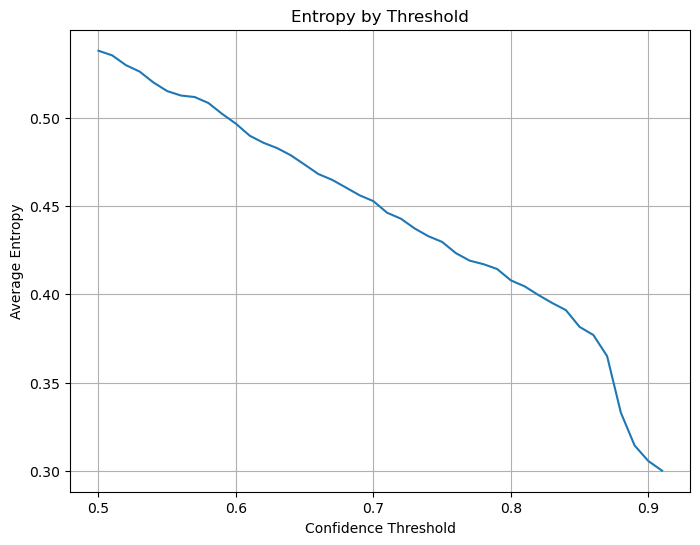

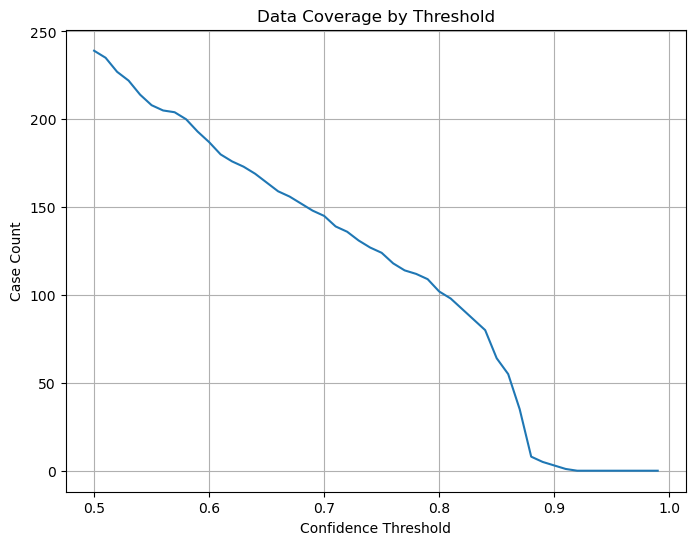

In [5]:
file_path = r'F:/code/calibration_test/mc-dropout_results_predictive_entropy.xlsx'
df = pd.read_excel(file_path)

thresholds = np.arange(0.5, 1.0, 0.01)
avg_entropy_list = []
case_count_list = []

for t in thresholds:
    filtered_df = df[df['confidence'] >= t]
    case_count = len(filtered_df)
    case_count_list.append(case_count)
    
    if case_count > 0:
        avg_entropy = filtered_df['predictive_entropy'].mean()
    else:
        avg_entropy = np.nan
        
    avg_entropy_list.append(avg_entropy)
    print(f"Threshold: {t:.2f}, Average Entropy: {avg_entropy:.4f}, Case Count: {case_count}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, avg_entropy_list, linestyle='-')
plt.title("Entropy by Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Average Entropy")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(thresholds, case_count_list, linestyle='-')
plt.title("Data Coverage by Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Case Count")
plt.grid(True)
plt.show()